In [3]:
import os
import numpy as np
np.random.seed(123) 
import pandas as pd

from glob import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread
from skimage.transform import resize
from skimage import exposure
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras import callbacks
import keras.backend as K
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D


In [46]:
# reading pathes 
BAZE_PATH = "data/"

names_raw = glob(os.path.join(BAZE_PATH,"Raws","*.png"))
names_labels = glob(os.path.join(BAZE_PATH,"Labels","*.png"))
names_raw.sort()
names_labels.sort()
print("Count raw files: ", len(names_raw))
print("Count labels files: ",len(names_labels))

Count raw files:  62
Count labels files:  62


[  0. 255.]
(908, 1196)


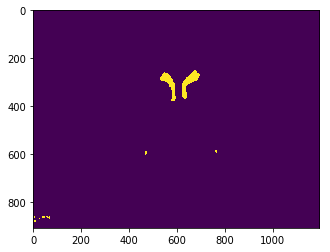

In [5]:
# Check values inside imgs
# check_img = imread(names_raw[10])
# check_mask = imread(names_labels[10])

# check_mask = np.array(check_mask)
# check_mask = rgb2grey(check_mask)
# check_mask[check_mask>0] = 255
# print(np.unique(check_mask))
# print(check_mask.shape)
# plt.imshow(check_mask)


In [15]:
# variable for resizing
sizes = 128

# Function for preparing raw png files
def preparation_raw(x):
    img = imread(x)[:,150:1058,:] # Read and crop image
    img = rgb2grey(img) # to grey image with 1 channel 
    img = resize(img, (sizes,sizes), mode="symmetric") # resizing
    img = np.reshape(img,[sizes,sizes,1]) # reshaping from [h,w] to [h,w,channel] here we have one
    return img
    
    # Uncomment to work with 3 channels pngs
#     img = imread(x)[:,150:1058,:] # Read and crop image
#     img = resize(img, (sizes,sizes), mode="symmetric") # resizing
#     return img

# function for preparing labels files
def preparation_labels(x):
    img = imread(x)[:,150:1058,:] # Read and crop image
    img = rgb2grey(img) # to grey image with 1 channel. Need to make mask
    img = resize(img, (sizes,sizes), mode="symmetric") # resizing
    img[img>0] = 1 # binarization to 0 and 1 view
    img = np.expand_dims(img, axis=2)
    return img

raws = np.stack([preparation_raw(i) for i in names_raw], 0)
labels = np.stack([preparation_labels(i) for i in names_labels], 0)


# Overfit part
# take only two images and teach NN with it
# raws = np.stack([preparation_raw(i) for i in names_raw[15:19]], 0)
# labels = np.stack([preparation_labels(i) for i in names_labels[15:19]], 0)

print(raws.shape)
print(labels.shape)

(62, 128, 128, 1)
(62, 128, 128, 1)


In [47]:
# print(labels.shape)

# import pandas as pd
# lb = labels[3]
# lb = np.reshape(lb, (sizes*sizes,1))
# lb = pd.DataFrame(lb)
# lb[0].value_counts()

TypeError: Invalid dimensions for image data

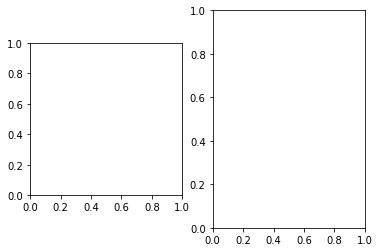

In [17]:
# Separating on train and test parts
X_train, X_test, y_train,  y_test = train_test_split(raws, labels, test_size=0.25)

# vis_X_train = np.reshape(X_train[2], (sizes,sizes)) # for raw image with 1 channel
vis_X_train = X_train[2] # for raw image with 3 channels

vis_y_train = np.reshape(y_train[2], (sizes,sizes))


vis_X_train.shape
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(vis_X_train, interpolation='nearest')
ax2.imshow(vis_y_train)


In [79]:
# Create a deep nn
# Here we don't use Dense layer
model = Sequential()
model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=raws.shape[1:],
                        padding='same'
                        ))
model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='sigmoid', 
                        padding='same'
                        ))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dense(64, activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Convolution2D(filters=1, 
                        kernel_size=(3, 3), 
                        activation='sigmoid', 
                        input_shape=raws.shape[1:],
                        padding='same'
                        ))


model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy','mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 1)         577       
Total params: 19,969
Trainable params: 19,969
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.10,
                    epochs=5000, 
                    batch_size=2,
                   )

Epoch 1/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0123 - acc: 0.9960 - mean_squared_error: 0.0032
Epoch 2/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0118 - acc: 0.9960 - mean_squared_error: 0.0031
Epoch 3/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0122 - acc: 0.9958 - mean_squared_error: 0.0033
Epoch 4/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0093 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 5/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0107 - acc: 0.9965 - mean_squared_error: 0.0028
Epoch 6/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0110 - acc: 0.9961 - mean_squared_error: 0.0030
Epoch 7/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0113 - acc: 0.9962 - mean_squared_error: 0.0030
Epoch 8/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0113 - acc: 0.9963 - mean_squared_error: 0.0029
Epoch 9/

46/46 [==============================] - 0s 6ms/step - loss: 0.0121 - acc: 0.9959 - mean_squared_error: 0.0032
Epoch 132/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0125 - acc: 0.9958 - mean_squared_error: 0.0033
Epoch 133/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0101 - acc: 0.9966 - mean_squared_error: 0.0027
Epoch 134/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0113 - acc: 0.9961 - mean_squared_error: 0.0031
Epoch 135/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0123 - acc: 0.9956 - mean_squared_error: 0.0034
Epoch 136/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0108 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 137/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0112 - acc: 0.9961 - mean_squared_error: 0.0030
Epoch 138/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0106 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 1

46/46 [==============================] - 0s 6ms/step - loss: 0.0090 - acc: 0.9971 - mean_squared_error: 0.0024
Epoch 262/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0097 - acc: 0.9969 - mean_squared_error: 0.0025
Epoch 263/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0120 - acc: 0.9960 - mean_squared_error: 0.0032
Epoch 264/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0094 - acc: 0.9967 - mean_squared_error: 0.0025
Epoch 265/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0161 - acc: 0.9952 - mean_squared_error: 0.0038
Epoch 266/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0091 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 267/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0129 - acc: 0.9956 - mean_squared_error: 0.0034
Epoch 268/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0105 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 2

46/46 [==============================] - 0s 6ms/step - loss: 0.0107 - acc: 0.9963 - mean_squared_error: 0.0028
Epoch 392/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0093 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 393/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0119 - acc: 0.9958 - mean_squared_error: 0.0033
Epoch 394/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.9967 - mean_squared_error: 0.0025
Epoch 395/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0107 - acc: 0.9962 - mean_squared_error: 0.0029
Epoch 396/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0090 - acc: 0.9970 - mean_squared_error: 0.0024
Epoch 397/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0112 - acc: 0.9962 - mean_squared_error: 0.0030
Epoch 398/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0112 - acc: 0.9961 - mean_squared_error: 0.0030
Epoch 3

46/46 [==============================] - 0s 6ms/step - loss: 0.0088 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 522/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0099 - acc: 0.9967 - mean_squared_error: 0.0026
Epoch 523/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0132 - acc: 0.9956 - mean_squared_error: 0.0035
Epoch 524/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0098 - acc: 0.9965 - mean_squared_error: 0.0026
Epoch 525/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0112 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 526/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0113 - acc: 0.9965 - mean_squared_error: 0.0029
Epoch 527/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0098 - acc: 0.9966 - mean_squared_error: 0.0026
Epoch 528/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.9967 - mean_squared_error: 0.0025
Epoch 5

46/46 [==============================] - 0s 6ms/step - loss: 0.0093 - acc: 0.9969 - mean_squared_error: 0.0025
Epoch 652/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0093 - acc: 0.9968 - mean_squared_error: 0.0025
Epoch 653/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0115 - acc: 0.9961 - mean_squared_error: 0.0030
Epoch 654/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0091 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 655/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0094 - acc: 0.9968 - mean_squared_error: 0.0025
Epoch 656/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0102 - acc: 0.9966 - mean_squared_error: 0.0026
Epoch 657/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0107 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 658/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0090 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 6

46/46 [==============================] - 0s 6ms/step - loss: 0.0168 - acc: 0.9952 - mean_squared_error: 0.0038
Epoch 782/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0078 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 783/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 784/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0100 - acc: 0.9967 - mean_squared_error: 0.0027
Epoch 785/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0098 - acc: 0.9967 - mean_squared_error: 0.0026
Epoch 786/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0114 - acc: 0.9963 - mean_squared_error: 0.0029
Epoch 787/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0085 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 788/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0086 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 7

46/46 [==============================] - 0s 6ms/step - loss: 0.0086 - acc: 0.9972 - mean_squared_error: 0.0023
Epoch 912/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0086 - acc: 0.9971 - mean_squared_error: 0.0023
Epoch 913/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.9968 - mean_squared_error: 0.0025
Epoch 914/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0105 - acc: 0.9963 - mean_squared_error: 0.0028
Epoch 915/5000
46/46 [==============================] - 0s 9ms/step - loss: 0.0104 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 916/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0075 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 917/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0092 - acc: 0.9968 - mean_squared_error: 0.0024
Epoch 918/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0106 - acc: 0.9964 - mean_squared_error: 0.0028
Epoch 9

46/46 [==============================] - 0s 6ms/step - loss: 0.0085 - acc: 0.9971 - mean_squared_error: 0.0023
Epoch 1041/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0086 - acc: 0.9971 - mean_squared_error: 0.0023
Epoch 1042/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0100 - acc: 0.9966 - mean_squared_error: 0.0026
Epoch 1043/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0099 - acc: 0.9966 - mean_squared_error: 0.0026
Epoch 1044/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0080 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 1045/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0097 - acc: 0.9966 - mean_squared_error: 0.0026
Epoch 1046/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0085 - acc: 0.9971 - mean_squared_error: 0.0023
Epoch 1047/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0087 - acc: 0.9970 - mean_squared_error: 0.0023


46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9974 - mean_squared_error: 0.0021
Epoch 1169/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0096 - acc: 0.9966 - mean_squared_error: 0.0026
Epoch 1170/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0096 - acc: 0.9970 - mean_squared_error: 0.0024
Epoch 1171/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0074 - acc: 0.9975 - mean_squared_error: 0.0019
Epoch 1172/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0101 - acc: 0.9967 - mean_squared_error: 0.0026
Epoch 1173/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0085 - acc: 0.9973 - mean_squared_error: 0.0022
Epoch 1174/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0091 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 1175/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0094 - acc: 0.9967 - mean_squared_error: 0.0025


46/46 [==============================] - 0s 6ms/step - loss: 0.0075 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 1297/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0094 - acc: 0.9968 - mean_squared_error: 0.0025
Epoch 1298/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.9968 - mean_squared_error: 0.0025
Epoch 1299/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 1300/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0091 - acc: 0.9968 - mean_squared_error: 0.0024
Epoch 1301/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0077 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 1302/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 1303/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0084 - acc: 0.9970 - mean_squared_error: 0.0023


46/46 [==============================] - 0s 7ms/step - loss: 0.0091 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 1425/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0078 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 1426/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0085 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 1427/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0080 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 1428/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0078 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 1429/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0084 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 1430/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0087 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 1431/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0121 - acc: 0.9960 - mean_squared_error: 0.0032


46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 1553/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0081 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 1554/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0091 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 1555/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0088 - acc: 0.9970 - mean_squared_error: 0.0024
Epoch 1556/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0082 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 1557/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0089 - acc: 0.9971 - mean_squared_error: 0.0023
Epoch 1558/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0081 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 1559/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0104 - acc: 0.9964 - mean_squared_error: 0.0028


46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 1681/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0080 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 1682/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0075 - acc: 0.9974 - mean_squared_error: 0.0020
Epoch 1683/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0087 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 1684/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0069 - acc: 0.9976 - mean_squared_error: 0.0018
Epoch 1685/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0092 - acc: 0.9971 - mean_squared_error: 0.0023
Epoch 1686/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0084 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 1687/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0090 - acc: 0.9970 - mean_squared_error: 0.0024


46/46 [==============================] - 0s 6ms/step - loss: 0.0088 - acc: 0.9969 - mean_squared_error: 0.0024
Epoch 1809/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0086 - acc: 0.9970 - mean_squared_error: 0.0024
Epoch 1810/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0065 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 1811/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0084 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 1812/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0078 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 1813/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0083 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 1814/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0074 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 1815/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0076 - acc: 0.9972 - mean_squared_error: 0.0021


46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 1937/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0070 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 1938/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0084 - acc: 0.9971 - mean_squared_error: 0.0022
Epoch 1939/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0065 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 1940/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.9969 - mean_squared_error: 0.0025
Epoch 1941/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0071 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 1942/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0085 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 1943/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0062 - acc: 0.9979 - mean_squared_error: 0.0017


46/46 [==============================] - 0s 6ms/step - loss: 0.0084 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 2065/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0085 - acc: 0.9973 - mean_squared_error: 0.0022
Epoch 2066/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0061 - acc: 0.9980 - mean_squared_error: 0.0016
Epoch 2067/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0074 - acc: 0.9973 - mean_squared_error: 0.0020
Epoch 2068/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0075 - acc: 0.9974 - mean_squared_error: 0.0020
Epoch 2069/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0078 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 2070/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0078 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 2071/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0073 - acc: 0.9976 - mean_squared_error: 0.0019


46/46 [==============================] - 0s 6ms/step - loss: 0.0062 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 2193/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0067 - acc: 0.9977 - mean_squared_error: 0.0018
Epoch 2194/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0083 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 2195/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0074 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 2196/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0069 - acc: 0.9976 - mean_squared_error: 0.0018
Epoch 2197/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0082 - acc: 0.9972 - mean_squared_error: 0.0022
Epoch 2198/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0067 - acc: 0.9977 - mean_squared_error: 0.0018
Epoch 2199/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0070 - acc: 0.9975 - mean_squared_error: 0.0019


46/46 [==============================] - 0s 6ms/step - loss: 0.0074 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 2321/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0058 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 2322/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0076 - acc: 0.9973 - mean_squared_error: 0.0020
Epoch 2323/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0067 - acc: 0.9977 - mean_squared_error: 0.0018
Epoch 2324/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0089 - acc: 0.9970 - mean_squared_error: 0.0024
Epoch 2325/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0077 - acc: 0.9974 - mean_squared_error: 0.0021
Epoch 2326/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0057 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 2327/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0078 - acc: 0.9972 - mean_squared_error: 0.0021


46/46 [==============================] - 0s 7ms/step - loss: 0.0055 - acc: 0.9981 - mean_squared_error: 0.0014
Epoch 2449/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0073 - acc: 0.9975 - mean_squared_error: 0.0020
Epoch 2450/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0071 - acc: 0.9975 - mean_squared_error: 0.0019
Epoch 2451/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0076 - acc: 0.9974 - mean_squared_error: 0.0020
Epoch 2452/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0063 - acc: 0.9979 - mean_squared_error: 0.0017
Epoch 2453/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0057 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 2454/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0076 - acc: 0.9973 - mean_squared_error: 0.0021
Epoch 2455/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0067 - acc: 0.9976 - mean_squared_error: 0.0018


46/46 [==============================] - 0s 8ms/step - loss: 0.0060 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 2577/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0070 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 2578/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0058 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 2579/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0078 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 2580/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0059 - acc: 0.9980 - mean_squared_error: 0.0016
Epoch 2581/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0066 - acc: 0.9977 - mean_squared_error: 0.0018
Epoch 2582/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0057 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 2583/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0086 - acc: 0.9973 - mean_squared_error: 0.0021


46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9983 - mean_squared_error: 0.0014
Epoch 2705/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0081 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 2706/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0077 - acc: 0.9974 - mean_squared_error: 0.0020
Epoch 2707/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9982 - mean_squared_error: 0.0014
Epoch 2708/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0063 - acc: 0.9978 - mean_squared_error: 0.0016
Epoch 2709/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0065 - acc: 0.9976 - mean_squared_error: 0.0018
Epoch 2710/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0052 - acc: 0.9983 - mean_squared_error: 0.0014
Epoch 2711/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0081 - acc: 0.9972 - mean_squared_error: 0.0022


46/46 [==============================] - 0s 6ms/step - loss: 0.0062 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 2833/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0060 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 2834/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0065 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 2835/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0053 - acc: 0.9983 - mean_squared_error: 0.0014
Epoch 2836/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0069 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 2837/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0070 - acc: 0.9975 - mean_squared_error: 0.0019
Epoch 2838/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 2839/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0064 - acc: 0.9977 - mean_squared_error: 0.0018


46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 2961/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0073 - acc: 0.9975 - mean_squared_error: 0.0019
Epoch 2962/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0056 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 2963/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0064 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 2964/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0073 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 2965/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0071 - acc: 0.9975 - mean_squared_error: 0.0019
Epoch 2966/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0045 - acc: 0.9986 - mean_squared_error: 0.0012
Epoch 2967/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0076 - acc: 0.9976 - mean_squared_error: 0.0019


46/46 [==============================] - 0s 6ms/step - loss: 0.0045 - acc: 0.9986 - mean_squared_error: 0.0012
Epoch 3089/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0063 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 3090/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0055 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 3091/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0059 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 3092/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0060 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 3093/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0050 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3094/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0060 - acc: 0.9980 - mean_squared_error: 0.0016
Epoch 3095/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0062 - acc: 0.9978 - mean_squared_error: 0.0017


46/46 [==============================] - 0s 6ms/step - loss: 0.0064 - acc: 0.9977 - mean_squared_error: 0.0017
Epoch 3217/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0043 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 3218/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0085 - acc: 0.9970 - mean_squared_error: 0.0023
Epoch 3219/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0051 - acc: 0.9982 - mean_squared_error: 0.0014
Epoch 3220/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3221/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0070 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 3222/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9982 - mean_squared_error: 0.0014
Epoch 3223/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0055 - acc: 0.9981 - mean_squared_error: 0.0014


46/46 [==============================] - 0s 6ms/step - loss: 0.0043 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 3345/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0071 - acc: 0.9975 - mean_squared_error: 0.0019
Epoch 3346/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0045 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 3347/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.9972 - mean_squared_error: 0.0021
Epoch 3348/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0038 - acc: 0.9988 - mean_squared_error: 9.6936e-04
Epoch 3349/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0058 - acc: 0.9979 - mean_squared_error: 0.0015
Epoch 3350/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0052 - acc: 0.9982 - mean_squared_error: 0.0014
Epoch 3351/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0059 - acc: 0.9980 - mean_squared_error: 0.0

46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 3473/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0055 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 3474/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 3475/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0055 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 3476/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 3477/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 3478/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0055 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 3479/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0077 - acc: 0.9973 - mean_squared_error: 0.0021


46/46 [==============================] - 0s 6ms/step - loss: 0.0052 - acc: 0.9982 - mean_squared_error: 0.0014
Epoch 3601/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0057 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 3602/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9987 - mean_squared_error: 0.0011
Epoch 3603/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0068 - acc: 0.9979 - mean_squared_error: 0.0017
Epoch 3604/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 3605/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9981 - mean_squared_error: 0.0014
Epoch 3606/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 3607/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9983 - mean_squared_error: 0.0013


46/46 [==============================] - 0s 6ms/step - loss: 0.0053 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 3729/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0052 - acc: 0.9981 - mean_squared_error: 0.0014
Epoch 3730/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3731/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0050 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3732/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0039 - acc: 0.9987 - mean_squared_error: 0.0010
Epoch 3733/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 3734/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3735/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0052 - acc: 0.9981 - mean_squared_error: 0.0014


46/46 [==============================] - 0s 8ms/step - loss: 0.0036 - acc: 0.9988 - mean_squared_error: 9.3208e-04
Epoch 3857/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3858/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0055 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 3859/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 3860/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0048 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3861/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0050 - acc: 0.9983 - mean_squared_error: 0.0014
Epoch 3862/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9982 - mean_squared_error: 0.0013
Epoch 3863/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0051 - acc: 0.9982 - mean_squared_error: 0.0

46/46 [==============================] - 0s 6ms/step - loss: 0.0036 - acc: 0.9988 - mean_squared_error: 9.4299e-04
Epoch 3985/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9982 - mean_squared_error: 0.0013
Epoch 3986/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0050 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 3987/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0056 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 3988/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0034 - acc: 0.9989 - mean_squared_error: 8.7683e-04
Epoch 3989/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0046 - acc: 0.9984 - mean_squared_error: 0.0012
Epoch 3990/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0044 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 3991/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0089 - acc: 0.9971 - mean_squared_error:

46/46 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0.9984 - mean_squared_error: 0.0012
Epoch 4113/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0051 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 4114/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0043 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 4115/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 4116/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0053 - acc: 0.9981 - mean_squared_error: 0.0014
Epoch 4117/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4118/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0059 - acc: 0.9980 - mean_squared_error: 0.0016
Epoch 4119/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0040 - acc: 0.9986 - mean_squared_error: 0.0011


46/46 [==============================] - 0s 6ms/step - loss: 0.0042 - acc: 0.9985 - mean_squared_error: 0.0011
Epoch 4241/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 4242/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0044 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 4243/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 4244/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0039 - acc: 0.9987 - mean_squared_error: 0.0010
Epoch 4245/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 4246/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4247/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0079 - acc: 0.9974 - mean_squared_error: 0.0020


46/46 [==============================] - 0s 7ms/step - loss: 0.0053 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 4369/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0033 - acc: 0.9990 - mean_squared_error: 8.6189e-04
Epoch 4370/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0044 - acc: 0.9984 - mean_squared_error: 0.0012
Epoch 4371/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 4372/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9987 - mean_squared_error: 9.9856e-04
Epoch 4373/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0070 - acc: 0.9976 - mean_squared_error: 0.0019
Epoch 4374/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0031 - acc: 0.9991 - mean_squared_error: 7.7442e-04
Epoch 4375/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0.9984 - mean_squared_er

46/46 [==============================] - 0s 6ms/step - loss: 0.0033 - acc: 0.9989 - mean_squared_error: 8.8741e-04
Epoch 4433/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4434/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0057 - acc: 0.9979 - mean_squared_error: 0.0016
Epoch 4435/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4436/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0037 - acc: 0.9988 - mean_squared_error: 9.7338e-04
Epoch 4437/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0048 - acc: 0.9983 - mean_squared_error: 0.0013
Epoch 4438/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0034 - acc: 0.9989 - mean_squared_error: 9.1719e-04
Epoch 4439/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0042 - acc: 0.9986 - mean_squared_er

46/46 [==============================] - 0s 6ms/step - loss: 0.0054 - acc: 0.9982 - mean_squared_error: 0.0014
Epoch 4497/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 4498/5000
46/46 [==============================] - 0s 8ms/step - loss: 0.0045 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 4499/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0040 - acc: 0.9987 - mean_squared_error: 0.0011
Epoch 4500/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0040 - acc: 0.9985 - mean_squared_error: 0.0011
Epoch 4501/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0042 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4502/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0043 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 4503/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0.9984 - mean_squared_error: 0.0013


46/46 [==============================] - 0s 6ms/step - loss: 0.0056 - acc: 0.9981 - mean_squared_error: 0.0015
Epoch 4561/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0027 - acc: 0.9991 - mean_squared_error: 6.8781e-04
Epoch 4562/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0059 - acc: 0.9980 - mean_squared_error: 0.0016
Epoch 4563/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 4564/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0031 - acc: 0.9991 - mean_squared_error: 7.8200e-04
Epoch 4565/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0051 - acc: 0.9981 - mean_squared_error: 0.0014
Epoch 4566/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0065 - acc: 0.9978 - mean_squared_error: 0.0017
Epoch 4567/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0025 - acc: 0.9993 - mean_squared_error:

46/46 [==============================] - 0s 7ms/step - loss: 0.0054 - acc: 0.9980 - mean_squared_error: 0.0015
Epoch 4688/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0045 - acc: 0.9987 - mean_squared_error: 0.0011
Epoch 4689/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0038 - acc: 0.9987 - mean_squared_error: 0.0010
Epoch 4690/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0040 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4691/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0033 - acc: 0.9989 - mean_squared_error: 8.7967e-04
Epoch 4692/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0043 - acc: 0.9985 - mean_squared_error: 0.0012
Epoch 4693/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0040 - acc: 0.9987 - mean_squared_error: 0.0011
Epoch 4694/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0.9984 - mean_squared_error: 0.0

46/46 [==============================] - 0s 6ms/step - loss: 0.0047 - acc: 0.9984 - mean_squared_error: 0.0012
Epoch 4814/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0028 - acc: 0.9991 - mean_squared_error: 6.9814e-04
Epoch 4815/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0045 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 4816/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0033 - acc: 0.9989 - mean_squared_error: 8.6287e-04
Epoch 4817/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4818/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 7.6338e-04
Epoch 4819/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9984 - mean_squared_error: 0.0013
Epoch 4820/5000
46/46 [==============================] - 0s 7ms/step - loss: 0.0051 - acc: 0.9982 - mean_squared_er

46/46 [==============================] - 0s 6ms/step - loss: 0.0066 - acc: 0.9979 - mean_squared_error: 0.0017
Epoch 4940/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 7.3471e-04
Epoch 4941/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0038 - acc: 0.9987 - mean_squared_error: 0.0010
Epoch 4942/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0031 - acc: 0.9990 - mean_squared_error: 7.8376e-04
Epoch 4943/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0039 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4944/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0042 - acc: 0.9986 - mean_squared_error: 0.0011
Epoch 4945/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - acc: 0.9984 - mean_squared_error: 0.0012
Epoch 4946/5000
46/46 [==============================] - 0s 6ms/step - loss: 0.0031 - acc: 0.9990 - mean_squared_error:

(1, 64, 64, 1)
[0.0000000e+00 1.1811724e-38 1.1850357e-38 ... 9.9999845e-01 9.9999905e-01
 9.9999964e-01]


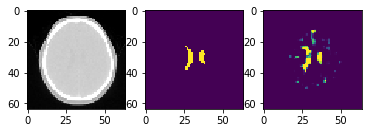

In [136]:

img_in_test_set = 10
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
x_tm = X_test[img_in_test_set]
# x_tm = np.reshape(x_tm, [sizes,sizes])
y_tm = y_test[img_in_test_set]
y_tm = np.reshape(y_tm, [sizes,sizes])

pred_tm = model.predict(X_test[img_in_test_set:img_in_test_set+1])
# pred_tm = pred_tm[0]

print(pred_tm.shape)
print(np.unique(pred_tm))
pred_tm = np.reshape(pred_tm[0], [sizes,sizes])
pred_tm[pred_tm > 0.9] = 1
# fig.figsize(8,16)
ax1.imshow(x_tm)
ax2.imshow(y_tm)
ax3.imshow(pred_tm)

(46, 64, 64, 1)


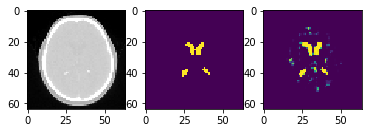

In [114]:
## Overfit tests

img_in_test_set = 1
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
x_tm = X_train[img_in_test_set]
# x_tm = np.reshape(x_tm, [sizes,sizes])
y_tm = y_train[img_in_test_set]
y_tm = np.reshape(y_tm, [sizes,sizes])

pred_tm = model.predict(X_train)
print(pred_tm.shape)

pred_tm = np.reshape(pred_tm[img_in_test_set], [sizes,sizes])

ax1.imshow(x_tm)
ax2.imshow(y_tm)
ax3.imshow(pred_tm)

In [104]:
np.amax(pred_tm)

9.995139e-08

In [137]:
model.save("v0.1.h5")

# Finetune test

In [9]:
model = keras.models.load_model("v0.2-finetune.h5")

In [49]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=550, 
                    batch_size=10,
                   )

Epoch 1/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0550 - acc: 0.9890 - mean_squared_error: 0.0110
Epoch 2/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0500 - acc: 0.9881 - mean_squared_error: 0.0113
Epoch 3/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0460 - acc: 0.9881 - mean_squared_error: 0.0109
Epoch 4/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0456 - acc: 0.9882 - mean_squared_error: 0.0103
Epoch 5/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0475 - acc: 0.9881 - mean_squared_error: 0.0108
Epoch 6/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0559 - acc: 0.9891 - mean_squared_error: 0.0117
Epoch 7/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0507 - acc: 0.9881 - mean_squared_error: 0.0114
Epoch 8/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0468 - acc: 0.9881 - mean_squared_error: 0.0111
Epoch 9/

46/46 [==============================] - 1s 15ms/step - loss: 0.0417 - acc: 0.9881 - mean_squared_error: 0.0100
Epoch 67/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0515 - acc: 0.9884 - mean_squared_error: 0.0108
Epoch 68/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0449 - acc: 0.9881 - mean_squared_error: 0.0104
Epoch 69/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0436 - acc: 0.9884 - mean_squared_error: 0.0097
Epoch 70/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0493 - acc: 0.9881 - mean_squared_error: 0.0112
Epoch 71/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0670 - acc: 0.9863 - mean_squared_error: 0.0153
Epoch 72/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0555 - acc: 0.9881 - mean_squared_error: 0.0116
Epoch 73/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0475 - acc: 0.9881 - mean_squared_error: 0.0112
Epoch 74/550


46/46 [==============================] - 1s 15ms/step - loss: 0.0400 - acc: 0.9881 - mean_squared_error: 0.0098
Epoch 132/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0507 - acc: 0.9888 - mean_squared_error: 0.0115
Epoch 133/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0589 - acc: 0.9881 - mean_squared_error: 0.0116
Epoch 134/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0463 - acc: 0.9881 - mean_squared_error: 0.0110
Epoch 135/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0429 - acc: 0.9881 - mean_squared_error: 0.0105
Epoch 136/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0459 - acc: 0.9891 - mean_squared_error: 0.0102
Epoch 137/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0483 - acc: 0.9881 - mean_squared_error: 0.0111
Epoch 138/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0458 - acc: 0.9882 - mean_squared_error: 0.0100
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0387 - acc: 0.9885 - mean_squared_error: 0.0091
Epoch 197/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0513 - acc: 0.9889 - mean_squared_error: 0.0106
Epoch 198/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0410 - acc: 0.9881 - mean_squared_error: 0.0100
Epoch 199/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0916 - acc: 0.9491 - mean_squared_error: 0.0286
Epoch 200/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0594 - acc: 0.9881 - mean_squared_error: 0.0117
Epoch 201/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0483 - acc: 0.9881 - mean_squared_error: 0.0113
Epoch 202/550
46/46 [==============================] - 1s 16ms/step - loss: 0.0447 - acc: 0.9881 - mean_squared_error: 0.0109
Epoch 203/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0443 - acc: 0.9881 - mean_squared_error: 0.0108
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0436 - acc: 0.9882 - mean_squared_error: 0.0106
Epoch 262/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0422 - acc: 0.9883 - mean_squared_error: 0.0098
Epoch 263/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0368 - acc: 0.9887 - mean_squared_error: 0.0089
Epoch 264/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0735 - acc: 0.9875 - mean_squared_error: 0.0143
Epoch 265/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0492 - acc: 0.9881 - mean_squared_error: 0.0112
Epoch 266/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0443 - acc: 0.9881 - mean_squared_error: 0.0107
Epoch 267/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0430 - acc: 0.9882 - mean_squared_error: 0.0106
Epoch 268/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0383 - acc: 0.9881 - mean_squared_error: 0.0095
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0417 - acc: 0.9891 - mean_squared_error: 0.0097
Epoch 327/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0454 - acc: 0.9889 - mean_squared_error: 0.0103
Epoch 328/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0528 - acc: 0.9881 - mean_squared_error: 0.0113
Epoch 329/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0381 - acc: 0.9882 - mean_squared_error: 0.0095
Epoch 330/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0728 - acc: 0.9880 - mean_squared_error: 0.0139
Epoch 331/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0462 - acc: 0.9882 - mean_squared_error: 0.0110
Epoch 332/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0425 - acc: 0.9882 - mean_squared_error: 0.0105
Epoch 333/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0399 - acc: 0.9885 - mean_squared_error: 0.0096
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0423 - acc: 0.9882 - mean_squared_error: 0.0103
Epoch 392/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0400 - acc: 0.9897 - mean_squared_error: 0.0087
Epoch 393/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0475 - acc: 0.9882 - mean_squared_error: 0.0109
Epoch 394/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0433 - acc: 0.9892 - mean_squared_error: 0.0094
Epoch 395/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0403 - acc: 0.9893 - mean_squared_error: 0.0092
Epoch 396/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0488 - acc: 0.9891 - mean_squared_error: 0.0104
Epoch 397/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0433 - acc: 0.9882 - mean_squared_error: 0.0106
Epoch 398/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0389 - acc: 0.9884 - mean_squared_error: 0.0094
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0540 - acc: 0.9888 - mean_squared_error: 0.0110
Epoch 457/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0454 - acc: 0.9891 - mean_squared_error: 0.0095
Epoch 458/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0399 - acc: 0.9882 - mean_squared_error: 0.0099
Epoch 459/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0437 - acc: 0.9892 - mean_squared_error: 0.0096
Epoch 460/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0449 - acc: 0.9875 - mean_squared_error: 0.0113
Epoch 461/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0718 - acc: 0.9881 - mean_squared_error: 0.0118
Epoch 462/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0447 - acc: 0.9882 - mean_squared_error: 0.0109
Epoch 463/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0418 - acc: 0.9882 - mean_squared_error: 0.0104
Epoch 

46/46 [==============================] - 1s 19ms/step - loss: 0.0566 - acc: 0.9882 - mean_squared_error: 0.0114
Epoch 522/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0434 - acc: 0.9883 - mean_squared_error: 0.0105
Epoch 523/550
46/46 [==============================] - 1s 19ms/step - loss: 0.0391 - acc: 0.9884 - mean_squared_error: 0.0097
Epoch 524/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0420 - acc: 0.9885 - mean_squared_error: 0.0099
Epoch 525/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0415 - acc: 0.9884 - mean_squared_error: 0.0095
Epoch 526/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0672 - acc: 0.9883 - mean_squared_error: 0.0135
Epoch 527/550
46/46 [==============================] - 1s 20ms/step - loss: 0.0522 - acc: 0.9882 - mean_squared_error: 0.0112
Epoch 528/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0380 - acc: 0.9883 - mean_squared_error: 0.0097
Epoch 

(1, 128, 128, 1)
[0.0000000e+00 2.0993473e-38 2.4222957e-38 ... 2.7069822e-01 2.7224839e-01
 2.8322077e-01]


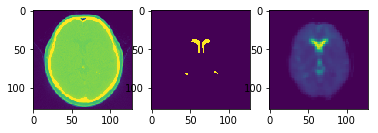

In [48]:
# Variable for choosing test image
img_in_test_set = 5

# Plotting comparing
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
x_tm = X_test[img_in_test_set]
x_tm = np.reshape(x_tm, [sizes,sizes])
y_tm = y_test[img_in_test_set]
y_tm = np.reshape(y_tm, [sizes,sizes])

pred_tm = model.predict(X_test[img_in_test_set:img_in_test_set+1])
# pred_tm = pred_tm[0]

print(pred_tm.shape)
print(np.unique(pred_tm))
pred_tm = np.reshape(pred_tm[0], [sizes,sizes])
pred_tm[pred_tm > 0.9] = 1
ax1.imshow(x_tm)
ax2.imshow(y_tm)
ax3.imshow(pred_tm)